<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_02/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb -qq

In [3]:
!pip install wandb --upgrade  # Upgrade wandb to the latest version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 51.3 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.19.7
    Uninstalling wandb-0.19.7:
      Successfully uninstalled wandb-0.19.7


In [4]:
!pip install tensorflow --upgrade

In [5]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninsta

# IMDB Sentiment Analysis with LSTM and WandB Integration

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import imdb
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from wandb.integration.keras import WandbCallback

## 2. Initialize WandB

In [2]:
wandb.init(project="IMDB-Sentiment-Analysis")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rutujapatil241997 (rutujapatil241997-san-jose-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 3. Load and Preprocess IMDB Dataset

In [3]:
vocab_size = 10000
maxlen = 200

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

17464789/17464789 [==============================] - 2s 0us/step


## 4. Build the LSTM Model

In [5]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


## 5. Train the Model

In [6]:

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, WandbCallback()]  # Use WandbCallback here
)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.7663

wandb: Adding directory to artifact (/content/wandb/run-20250305_195317-77dy9g71/files/model-best)... Done. 0.1s


313/313 [==============================] - 208s 646ms/step - loss: 0.4715 - accuracy: 0.7663 - val_loss: 0.3110 - val_accuracy: 0.8714
Epoch 2/10
313/313 [==============================] - 166s 529ms/step - loss: 0.2604 - accuracy: 0.8976 - val_loss: 0.3739 - val_accuracy: 0.8366
Epoch 3/10
313/313 [==============================] - 166s 529ms/step - loss: 0.1871 - accuracy: 0.9313 - val_loss: 0.3390 - val_accuracy: 0.8604
Epoch 4/10
313/313 [==============================] - 174s 558ms/step - loss: 0.1346 - accuracy: 0.9545 - val_loss: 0.3627 - val_accuracy: 0.8678


## 6. Evaluate the *Model*

In [7]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

782/782 [==============================] - 45s 58ms/step - loss: 0.3801 - accuracy: 0.8614
Test Accuracy: 0.8613600134849548


In [9]:
# Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


782/782 [==============================] - 65s 82ms/step


In [10]:
# 7. Metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



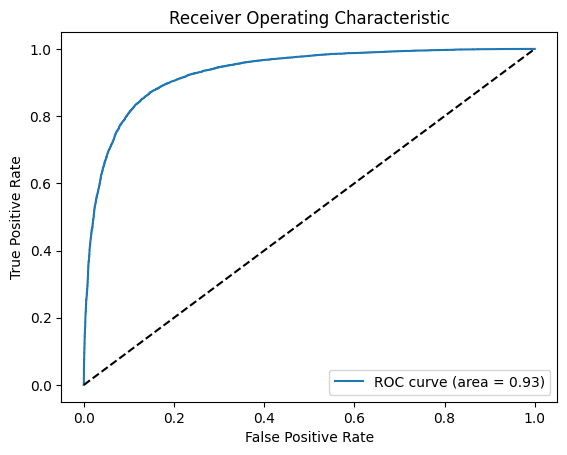

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

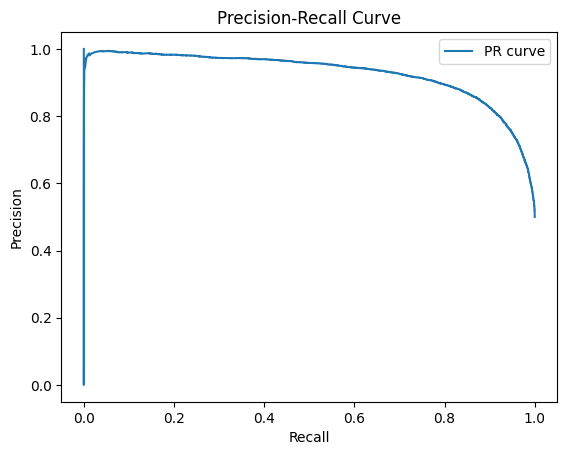

In [12]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(recall, precision, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

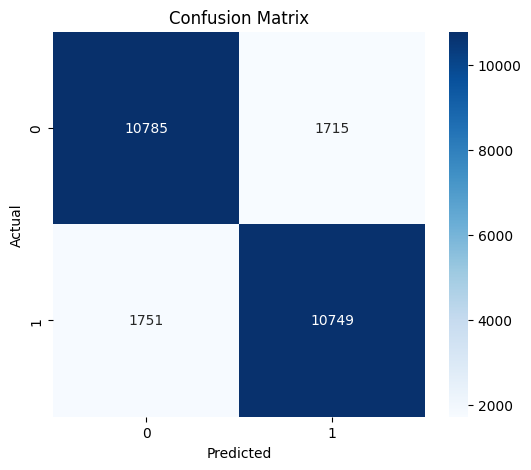

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# 8. Error Analysis
false_positives = np.where((y_pred == 1) & (y_test == 0))[0]
false_negatives = np.where((y_pred == 0) & (y_test == 1))[0]
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

False Positives: 155800000
False Negatives: 156700000


In [15]:
# Save Model
model.save("imdb_sentiment_lstm.h5")

In [16]:
# Finish WandB Run
wandb.finish()

accuracy,▁▆▇█
epoch,▁▃▆█
loss,█▄▂▁
val_accuracy,█▁▆▇
val_loss,▁█▄▇
accuracy,0.9545
best_epoch,0
best_val_loss,0.31099
epoch,3
loss,0.13462
val_accuracy,0.8678
